In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from sympy import divisors
from dataclasses import dataclass
import math
from typing import Callable

## Language model and GPU definitions

This section contains a transformer class and a GPU class, along with object definitions for important models and GPUs. Details such as whether a GPU should be assumed to have a kernel launch latency or what the latency structure of GPU collectives is like are also handled here.

By default, we use the latency function from the NCCL Tests repository. These might correspond to collective kernels that have been insufficiently optimized - to get results in a more optimized setting, you can adjust the functions implementing time taken per collective as needed.

In [171]:
class Model:
    def __init__(self, name="None", d_model=3*2**12, d_ff=9*2**12, ff_matrix_count=(1, 1), layers=120, n_experts=1, n_active_experts=1, num_query_heads=128, group_size=1, \
                 weight_precision_bytes=2, activation_precision_bytes=2, d_head=None, vocab_size=0, parallel_attention=False):
        assert num_query_heads % group_size == 0

        # Variables directly set
        self.d_model = d_model
        self.d_ff = d_ff
        self.layers = layers
        self.n_experts = n_experts
        self.n_active_experts = n_active_experts
        self.num_query_heads = num_query_heads
        self.group_size = group_size
        self.weight_precision_bytes = weight_precision_bytes
        self.activation_precision_bytes = activation_precision_bytes
        self.vocab_size = vocab_size
        self.ff_matrix_count = ff_matrix_count
        self.parallel_attention = parallel_attention

        # Derived variables
        self.ff_params_per_layer_per_expert = sum(self.ff_matrix_count) * self.d_model * self.d_ff
        self.sparsity_factor = self.n_experts // self.n_active_experts
        self.total_ff_params = self.layers * self.n_experts * self.ff_params_per_layer_per_expert
        self.num_kv_heads = 2 * self.num_query_heads//self.group_size
        self.d_head = d_head if d_head != None else self.d_model // self.num_query_heads
        self.d_all_attn_heads = (self.num_query_heads + self.num_kv_heads) * self.d_head
        self.attn_params_per_layer = self.d_all_attn_heads * self.d_model + self.d_head*self.num_query_heads*self.d_model

        self.embedding_params = self.vocab_size * self.d_model * 2
        self.total_attn_params = self.layers * self.attn_params_per_layer
        self.total_params = self.total_attn_params + self.total_ff_params + self.embedding_params
        self.total_active_params = self.total_attn_params + self.total_ff_params//self.sparsity_factor + self.embedding_params

        self.kv_cache_size_per_input_bytes = self.num_kv_heads*self.d_head*self.layers*self.activation_precision_bytes

        self.name = name

    def __repr__(self):
        representation = f"""Model Details:
        Name: {self.name}
        d_model: {self.d_model}
        d_ff: {self.d_ff}
        Depth: {self.layers}
        Total FF Params: {self.total_ff_params}
        Total Embedding Params: {self.embedding_params}
        Num Attention Heads: {self.num_query_heads}
        d_head: {self.d_head}
        Group size: {self.group_size}
        Total Attention Params: {self.total_attn_params}
        Total Params: {self.total_params}
        Total Active Params: {self.total_active_params}
        """
        return representation

    def arithmetic_cost_flop(self, input_len, batch_size, seq_len=1):
        mean_input_len = (input_len + (input_len + seq_len - 1))/2
        return (2*self.total_active_params*batch_size*seq_len + 2*self.d_head*self.num_query_heads*self.layers*mean_input_len*batch_size*seq_len)

    def memory_reads_writes_bytes(self, input_len, batch_size, tp_first_dim, tp_second_dim):
        kv_cache_size_bytes = self.kv_cache_size_per_input_bytes*input_len*batch_size

        used_experts_fraction = (1 - (1 - 1/self.sparsity_factor)**batch_size)
        wp = self.weight_precision_bytes
        ap = self.activation_precision_bytes

        feedforward_matmul_rw_bytes = used_experts_fraction * self.n_experts * sum(self.ff_matrix_count) * \
                                         (wp*self.d_model*self.d_ff + tp_second_dim*ap*self.d_model*batch_size + tp_first_dim*ap*self.d_ff*batch_size)

        qkv_matmul_rw_bytes = wp*self.d_model*self.d_all_attn_heads + tp_second_dim*ap*(self.d_model*batch_size) + tp_first_dim*(self.d_all_attn_heads*batch_size)

        proj_matmul_rw_bytes = wp*self.d_head*self.num_query_heads*self.d_model + \
                               ap*(tp_second_dim*self.d_model*batch_size + tp_first_dim*self.d_head*self.num_query_heads*batch_size)

        unembedding_bytes = wp*self.vocab_size*self.d_model

        return kv_cache_size_bytes + self.layers*(feedforward_matmul_rw_bytes + qkv_matmul_rw_bytes + proj_matmul_rw_bytes) + unembedding_bytes

GPT_4 = Model(name="GPT-4",
              d_model=12288,
              d_ff=3*12288,
              layers=120,
              n_experts=16,
              n_active_experts=2,
              num_query_heads=96,
              group_size=96,
              d_head=3*12288//(2*96),
              activation_precision_bytes=2,
              weight_precision_bytes=2,
              vocab_size=100256,
)

GPT_3_5 = Model(name="GPT 3.5",
                d_model=2**9 * 3**2,
                d_ff=4 * 2**9 * 3**2,
                layers=32,
                n_experts=4,
                n_active_experts=2,
                num_query_heads=32,
                group_size=32,
                activation_precision_bytes=2,
                weight_precision_bytes=2
)

GPT_3 = Model(name="GPT-3",
              d_model=12288,
              d_ff=4*12288,
              layers=96,
              n_experts=1,
              n_active_experts=1,
              num_query_heads=96,
              d_head=128,
              activation_precision_bytes=2,
              weight_precision_bytes=2,
              vocab_size=50257
)

PaLM_540B = Model(name="PaLM 540B",
                  d_model=18432,
                  d_ff=73728,
                  ff_matrix_count=(2, 1),
                  layers=118,
                  n_experts=1,
                  n_active_experts=1,
                  num_query_heads=48,
                  d_head=256,
                  group_size=48,
                  activation_precision_bytes=2,
                  weight_precision_bytes=2,
                  vocab_size=256000,
                  parallel_attention=True
)

PaLM_8B = Model(name="PaLM 8B",
                d_model=4096,
                d_ff=4*4096,
                ff_matrix_count=(2, 1),
                layers=32,
                num_query_heads=16,
                group_size=16,
                d_head=256,
                activation_precision_bytes=2,
                weight_precision_bytes=1,
                vocab_size=256000,
                parallel_attention=True
)

Falcon = Model(name="Falcon 180B",
               d_model=14848,
               d_ff=4*14848,
               layers=80,
               d_head=64,
               num_query_heads=232,
               group_size=232,
               activation_precision_bytes=2,
               weight_precision_bytes=2,
               vocab_size=65024
)

GPT_J_6B = Model(name="GPT-J 6B",
                 d_model=4096,
                 d_ff=4*4096,
                 layers=28,
                 num_query_heads=16,
                 d_head=256,
                 group_size=1,
                 activation_precision_bytes=2,
                 weight_precision_bytes=2,
                 vocab_size=50257
)

Mixtral_8x22B = Model(name="Mixtral 8x22B",
                      d_model=6144,
                      d_ff=16384,
                      ff_matrix_count=(2, 1),
                      layers=56,
                      n_experts=8,
                      n_active_experts=2,
                      num_query_heads=48,
                      d_head=128,
                      group_size=6,
                      activation_precision_bytes=2,
                      weight_precision_bytes=2,
                      vocab_size=32000
)

Mixtral_8x7B = Model(name="Mixtral 8x7B",
                      d_model=4096,
                      d_ff=14336,
                      ff_matrix_count=(2, 1),
                      layers=32,
                      n_experts=8,
                      n_active_experts=2,
                      num_query_heads=32,
                      group_size=4,
                     activation_precision_bytes=2,
                      weight_precision_bytes=2,
                      vocab_size=32000
)

Llama_3_8B = Model(name="LLaMa 3 8B",
                    d_model=4096,
                    d_ff=14336,
                    ff_matrix_count=(2, 1),
                    layers=32,
                    n_experts=1,
                    n_active_experts=1,
                    num_query_heads=32,
                    group_size=4,
                    activation_precision_bytes=2,
                    weight_precision_bytes=2,
                    vocab_size=128256
)

Llama_3_8B_8_bit = Model(name="LLaMa 3 8B",
                        d_model=4096,
                        d_ff=14336,
                        ff_matrix_count=(2, 1),
                        layers=32,
                        n_experts=1,
                        n_active_experts=1,
                        num_query_heads=32,
                        group_size=4,
                        activation_precision_bytes=1,
                        weight_precision_bytes=2,
                        vocab_size=128256
)

Llama_3_70B = Model(name="LLaMa 3 70B",
                    d_model=8192,
                    d_ff=28672,
                    ff_matrix_count=(2, 1),
                    layers=80,
                    n_experts=1,
                    n_active_experts=1,
                    num_query_heads=64,
                    group_size=8,
                    activation_precision_bytes=2,
                    weight_precision_bytes=2,
                    vocab_size=128256
)

Llama_3_70B_8_bit = Model(name="LLaMa 3 70B 8-bit",
                    d_model=8192,
                    d_ff=28672,
                    ff_matrix_count=(2, 1),
                    layers=80,
                    n_experts=1,
                    n_active_experts=1,
                    num_query_heads=64,
                    group_size=8,
                    activation_precision_bytes=2,
                    weight_precision_bytes=1,
                    vocab_size=128256
)

Llama_3_70B_4_bit = Model(name="LLaMa 3 70B 4-bit",
                    d_model=8192,
                    d_ff=28672,
                    ff_matrix_count=(2, 1),
                    layers=80,
                    n_experts=1,
                    n_active_experts=1,
                    num_query_heads=64,
                    group_size=8,
                    activation_precision_bytes=2,
                    weight_precision_bytes=0.5,
                    vocab_size=128256
)

Llama_3_405B = Model(name="LLaMa 3 405B",
                    d_model=16384,
                    d_ff=53248,
                    ff_matrix_count=(2, 1),
                    layers=126,
                    n_experts=1,
                    n_active_experts=1,
                    num_query_heads=128,
                    group_size=8,
                    activation_precision_bytes=2,
                    weight_precision_bytes=2,
                    vocab_size=128256
)

Llama_3_405B_8_bit = Model(name="LLaMa 3 405B",
                    d_model=16384,
                    d_ff=53248,
                    ff_matrix_count=(2, 1),
                    layers=126,
                    n_experts=1,
                    n_active_experts=1,
                    num_query_heads=128,
                    group_size=8,
                    activation_precision_bytes=2,
                    weight_precision_bytes=1,
                    vocab_size=128256
)

class GPU:
    name: str
    flop_per_second: float
    theoretical_flop_per_second: float
    hbm_bandwidth_Bps: float
    theoretical_hbm_bandwidth_Bps: float
    hbm_size_bytes: float
    l2_bandwidth_Bps: float
    l2_cache_size_bytes: float
    intranode_allreduce_bandwidth_Bps: float
    internode_allreduce_bandwidth_Bps: float
    node_size: int
    price_dollars_per_hour: float
    kernel_launch_latency_seconds: float
    collective_time_seconds: Callable[[float, float, float, 'GPU', str, tuple[int]], float]

    def __init__(self,
                 name: str,
                 flop_per_second: dict,
                 hbm_bandwidth_Bps: float,
                 hbm_size_bytes: float,
                 l2_bandwidth_Bps: float,
                 l2_cache_size_bytes: float,
                 intranode_allreduce_bandwidth_Bps: float,
                 internode_allreduce_bandwidth_Bps: float,
                 node_size: int,
                 price_dollars_per_hour: float,
                 kernel_launch_latency_seconds: float,
                 collective_time_seconds: Callable[[float, float, float, 'GPU', str, tuple[int]], float],
                 arithmetic_utilization_cap=1,
                 memory_bwd_utilization_cap=1):
        self.name = name
        self.theoretical_flop_per_second = flop_per_second
        self.theoretical_hbm_bandwidth_Bps = hbm_bandwidth_Bps
        self.flop_per_second = {p: flop_per_second[p]*arithmetic_utilization_cap for p in flop_per_second}
        self.hbm_bandwidth_Bps = hbm_bandwidth_Bps*memory_bwd_utilization_cap
        self.hbm_size_bytes = hbm_size_bytes
        self.l2_bandwidth_Bps = l2_bandwidth_Bps
        self.l2_cache_size_bytes = l2_cache_size_bytes
        self.intranode_allreduce_bandwidth_Bps = intranode_allreduce_bandwidth_Bps
        self.internode_allreduce_bandwidth_Bps = internode_allreduce_bandwidth_Bps
        self.node_size = node_size
        self.price_dollars_per_hour = price_dollars_per_hour
        self.kernel_launch_latency_seconds = kernel_launch_latency_seconds
        self.collective_time_seconds = collective_time_seconds
        self.arithmetic_utilization_cap = arithmetic_utilization_cap
        self.memory_bwd_utilization_cap = memory_bwd_utilization_cap

def collective_latency_nccl_seconds(nRanks, nNodes, coll="allreduce", algo="LL"):
   if coll == "allreduce":
     m = 2
   else:
     m = 1

   if algo == "LL":
      return m * ((nRanks/nNodes - 1)*0.6e-6 + 5e-6*np.log2(nNodes)) + 6.8e-6
   elif algo == "LL128":
      return m * ((nRanks/nNodes - 1)*1.25e-6 + 8.5e-6*np.log2(nNodes)) + 14e-6
   elif algo == "Simple":
      return m * ((nRanks/nNodes - 1)*28e-6 + 28e-6*np.log2(nNodes))
   else:
      raise ValueError("Algorithm code given to collective_latency_nccl_seconds is invalid.")

def mean_collective_time_nccl_seconds(nRanks, nNodes, bytes_reduced, gpu: GPU, coll="allreduce", latency_bw_weights=(1, 1)):
    result = np.infty * np.ones(shape=np.shape(nRanks))
    weighted_result = np.infty * np.ones(shape=np.shape(nRanks))

    assert np.all(nNodes <= np.maximum(1, nRanks)) and np.all(nNodes >= nRanks/gpu.node_size)

    if coll == "allreduce":
        m = 2
    else:
        m = 1

    algorithm_bandwidth_factors = {"Simple": 1,
                                    "LL128": 0.95,
                                    "LL": 0.5}

    if coll == "p2p":
       assert np.all(nRanks == 2)

    lat_weight, bw_weight = latency_bw_weights

    for algo in algorithm_bandwidth_factors:
      bw_factor = algorithm_bandwidth_factors[algo]
      curr_latency_time_seconds = collective_latency_nccl_seconds(nRanks, nNodes, coll=coll, algo=algo)
      curr_bw_time_seconds = nNodes*np.maximum(0, nRanks/nNodes - 1)*bytes_reduced/(nRanks*gpu.intranode_allreduce_bandwidth_Bps*bw_factor) + \
                             (nNodes-1)*bytes_reduced/(nRanks*gpu.internode_allreduce_bandwidth_Bps*bw_factor)
      
      if coll != "allreduce":
       curr_bw_time_seconds /= 2

      nonlinear_correction_time_seconds = np.zeros(shape=np.shape(nRanks))

      curr_result = curr_latency_time_seconds + curr_bw_time_seconds + nonlinear_correction_time_seconds
      smaller_indices = np.where(curr_result < result)

      result = np.minimum(result, curr_latency_time_seconds + curr_bw_time_seconds + nonlinear_correction_time_seconds)

      weighted_result[smaller_indices] = lat_weight*curr_latency_time_seconds[smaller_indices] + \
                                         bw_weight*curr_bw_time_seconds[smaller_indices] + \
                                         bw_weight*nonlinear_correction_time_seconds[smaller_indices]

    result[np.where(nRanks <= 1)] = 0
    weighted_result[np.where(nRanks <= 1)] = 0

    return weighted_result

def tpu_collective_time_seconds(nRanks, nNodes, bytes_reduced, gpu: GPU, coll="allreduce", latency_bw_weights=(1, 1)):
    if coll == "allreduce":
        m = 2
    else:
        m = 1

    if coll == "p2p":
        assert np.all(nRanks == 2)

    lat_weight, bw_weight = latency_bw_weights

    curr_latency_time_seconds = m*(nRanks-1)*1e-6
    curr_bw_time_seconds = (nRanks-1)*bytes_reduced/(nRanks*gpu.internode_allreduce_bandwidth_Bps)

    if coll != "allreduce":
       curr_bw_time_seconds /= 2

    nonlinear_correction_time_seconds = np.zeros(shape=np.shape(nRanks)) # 1e-6 * bytes_reduced**0.3345
    result = lat_weight*curr_latency_time_seconds + bw_weight*curr_bw_time_seconds + bw_weight*nonlinear_correction_time_seconds

    result[np.where(nRanks <= 1)] = 0
    return result


H100 = GPU(name="H100",
           flop_per_second={4: 2e15, 8: 2e15, 16: 1e15},
           hbm_bandwidth_Bps=3.3e12,
           hbm_size_bytes=8e10,
           l2_cache_size_bytes=2.5e7,
           l2_bandwidth_Bps=1.2e13,
           intranode_allreduce_bandwidth_Bps=9e11/4,
           internode_allreduce_bandwidth_Bps=5e10/2,
           node_size=8,
           price_dollars_per_hour=3.15*2/3,
           kernel_launch_latency_seconds=4e-6,
           collective_time_seconds=mean_collective_time_nccl_seconds,
           arithmetic_utilization_cap=1,
           memory_bwd_utilization_cap=1
)

H200 = GPU(name="H200",
           flop_per_second={4: 2e15, 8: 2e15, 16: 1e15},
           hbm_bandwidth_Bps=4.8e12,
           hbm_size_bytes=141e9,
           l2_cache_size_bytes=2.5e7,
           l2_bandwidth_Bps=1.2e13,
           intranode_allreduce_bandwidth_Bps=9e11/4,
           internode_allreduce_bandwidth_Bps=5e10/2,
           node_size=8,
           price_dollars_per_hour=3.15*2/3,
           kernel_launch_latency_seconds=4e-6,
           collective_time_seconds=mean_collective_time_nccl_seconds,
           arithmetic_utilization_cap=1,
           memory_bwd_utilization_cap=1)

A100 = GPU(name="A100",
           flop_per_second={8: 6.24e14, 16: 3.12e14},
           hbm_bandwidth_Bps=2e12,
           hbm_size_bytes=8e10,
           l2_cache_size_bytes=2.5e7,
           l2_bandwidth_Bps=1.2e13,
           intranode_allreduce_bandwidth_Bps=6e11/4,
           internode_allreduce_bandwidth_Bps=2.5e10/2,
           node_size=8,
           price_dollars_per_hour=2.26*2/3,
           kernel_launch_latency_seconds=4e-6,
           collective_time_seconds=mean_collective_time_nccl_seconds,
           arithmetic_utilization_cap=1,
           memory_bwd_utilization_cap=1
)
V100 = GPU(name="V100",
           flop_per_second={8: 1e14, 16: 1e14},
           hbm_bandwidth_Bps=9e11,
           hbm_size_bytes=1.6e10,
           l2_cache_size_bytes=2.5e7,
           l2_bandwidth_Bps=3e12,
           intranode_allreduce_bandwidth_Bps=3e11/4,
           internode_allreduce_bandwidth_Bps=1.25e10/2,
           node_size=8,
           price_dollars_per_hour=0.63*2/3,
           kernel_launch_latency_seconds=4e-6,
           collective_time_seconds=mean_collective_time_nccl_seconds,
           arithmetic_utilization_cap=1,
           memory_bwd_utilization_cap=1
)
TPU_v4 = GPU(name="TPU v4",
             flop_per_second={8: 2.6e14, 16: 2.6e14},
             hbm_bandwidth_Bps=1.6e12,
             hbm_size_bytes=32e9,
             l2_cache_size_bytes=5e4,
             l2_bandwidth_Bps=6.44e12,
             intranode_allreduce_bandwidth_Bps=np.infty,
             internode_allreduce_bandwidth_Bps=2.5e11,
             node_size=1,
             price_dollars_per_hour=1,
             kernel_launch_latency_seconds=4e-6,
             collective_time_seconds=tpu_collective_time_seconds,
)
Groq_LPU = GPU(name="Groq LPU",
               flop_per_second={8: 750e12, 16: 188e12},
               hbm_bandwidth_Bps=8e13,
               hbm_size_bytes=230e6,
               l2_cache_size_bytes=0,
               l2_bandwidth_Bps=np.infty,
               intranode_allreduce_bandwidth_Bps=np.infty,
               internode_allreduce_bandwidth_Bps=330e9/2,
               node_size=1,
               price_dollars_per_hour=1,
               kernel_launch_latency_seconds=4e-6,
               collective_time_seconds=tpu_collective_time_seconds,
)

In [73]:
1e6 * Groq_LPU.collective_time_seconds(nRanks=np.array([16.0]), nNodes=np.array([16]), bytes_reduced=np.array([1e4]), gpu=H200, coll="allreduce", latency_bw_weights=(1, 1))

array([30.375])

## Token latency functions

This section implements all of the token latency functions that are discussed in the paper, and an additional more complex one that handles complications such as pipeline parallelism.

In [240]:
def section_2_2_token_latency_seconds(N_GPU, model: Model, gpu: GPU, batch_size, input_len=0):
   t_reduce_seconds = 2e-6 * np.maximum(N_GPU**(1/2) - 1, 0) + 6e-6
   t_matmul_seconds = 0

   if model.parallel_attention:
      allreduces_per_layer = 2
   else:
      allreduces_per_layer = 4

   result = model.layers*allreduces_per_layer*t_reduce_seconds + np.maximum(model.weight_precision_bytes*model.total_params/(N_GPU*gpu.hbm_bandwidth_Bps), \
                                                                                    2*model.total_params*batch_size/(N_GPU*gpu.flop_per_second[8*model.weight_precision_bytes]))
   kv_cache_size_bytes = model.kv_cache_size_per_input_bytes * input_len * batch_size
   result[np.where(N_GPU * gpu.hbm_size_bytes < kv_cache_size_bytes + model.weight_precision_bytes*model.total_params)] = float("inf")

   return result

"""
The token latency function as presented in the paper.
This implementation follows the description in Section 3.5 exactly.
"""
def token_latency_seconds_as_presented_in_paper(N_GPU, model: Model, gpu: GPU, batch_size, input_len=0, seq_len=1):
   serial_matmuls_per_layer = 4
   nRanks = N_GPU**(1/2)
   nNodes = np.ceil(N_GPU/gpu.node_size)**(1/2)
   nParallelReduces = N_GPU/nRanks

   words_reduced = [model.d_head*(model.num_kv_heads + model.num_query_heads)/nParallelReduces, model.d_model/nParallelReduces, \
                    model.n_active_experts*model.ff_matrix_count[0]*model.d_ff/nParallelReduces, \
                    model.n_active_experts*model.ff_matrix_count[1]*model.d_model/nParallelReduces]

   arithmetic_cost_flop = model.arithmetic_cost_flop(input_len, batch_size*seq_len)
   kv_cache_size_bytes = model.kv_cache_size_per_input_bytes * input_len * batch_size

   memory_rw_bytes = model.memory_reads_writes_bytes(input_len, batch_size*seq_len, N_GPU**(1/2), N_GPU**(1/2))

   network_comm_time_sec = np.zeros(shape=np.shape(N_GPU))
   network_bw_time_sec = np.zeros(shape=np.shape(N_GPU))
   network_latency_time_sec = np.zeros(shape=np.shape(N_GPU))

   for words_reduced_sample in words_reduced:
       bytes_reduced = words_reduced_sample * batch_size * seq_len * model.activation_precision_bytes
       network_comm_time_sec += model.layers * gpu.collective_time_seconds(nRanks, nNodes, bytes_reduced, gpu, "allreduce", latency_bw_weights=(1, 1))

       network_bw_time_sec += model.layers * gpu.collective_time_seconds(nRanks, nNodes, bytes_reduced, gpu, "allreduce", latency_bw_weights=(0, 1))
       network_latency_time_sec += model.layers * gpu.collective_time_seconds(nRanks, nNodes, bytes_reduced, gpu, "allreduce", latency_bw_weights=(1, 0))

   result = (model.layers*serial_matmuls_per_layer*gpu.kernel_launch_latency_seconds) + network_comm_time_sec \
            + np.maximum( memory_rw_bytes/(N_GPU*gpu.hbm_bandwidth_Bps), \
                              arithmetic_cost_flop/(N_GPU*gpu.flop_per_second[8*model.weight_precision_bytes]))

   kv_cache_size_bytes = model.kv_cache_size_per_input_bytes * input_len * batch_size
   result[np.where(N_GPU * gpu.hbm_size_bytes < kv_cache_size_bytes + model.weight_precision_bytes*model.total_params)] = float("inf")

   return result

"""
This token latency function has some additional capabilities over the one presented in the paper.
It enables turning 2D TP on/off and properly handles pipeline parallelism.
These make a small difference when working with NVIDIA hardware but are important if we want to apply the model to e.g. Groq LPUs.
"""
def final_token_latency_seconds(N_GPU, model: Model, gpu: GPU, batch_size, input_len=0, seq_len=1):
   result = float("inf") * np.ones(shape=np.shape(N_GPU))
   if np.shape(batch_size) != np.shape(N_GPU):
      batch_size = batch_size * np.ones(shape=np.shape(N_GPU))

   for two_d_tensor_parallel in [True, False]:
    for N_PP in divisors(model.layers):
        N_TP = N_GPU/N_PP
        interleaving_factor = 1 # redundant modeling of pipeline interleaving

        for num_of_microbatches in N_PP * np.logspace(0, 4, num=4, base=2):
          microbatch_size = batch_size/num_of_microbatches
          
          bubble_fraction = (N_PP - 1)/(N_PP - 1 + interleaving_factor*num_of_microbatches)
          serial_matmuls_per_layer = 4

          if two_d_tensor_parallel:
              nRanks = N_TP**(1/2)
              nParallelReduces = N_TP/nRanks
              nNodes = np.ceil(N_TP/gpu.node_size)**(1/2)

              words_reduced = [model.d_head*(model.num_kv_heads + model.num_query_heads)/nParallelReduces, model.d_model/nParallelReduces, \
                               model.n_active_experts*model.ff_matrix_count[0]*model.d_ff/nParallelReduces, \
                               model.n_active_experts*model.ff_matrix_count[1]*model.d_model/nParallelReduces]
          else:
              words_reduced = [model.d_model/nParallelReduces, model.ff_matrix_count[1]*model.d_model/nParallelReduces]

              nRanks = N_TP
              nParallelReduces = N_TP/nRanks
              nNodes = np.ceil(N_TP/gpu.node_size)

          arithmetic_cost_flop = model.arithmetic_cost_flop(input_len, batch_size*seq_len)
          kv_cache_size_bytes = model.kv_cache_size_per_input_bytes * input_len * batch_size

          if two_d_tensor_parallel:
            memory_rw_bytes = num_of_microbatches * model.memory_reads_writes_bytes(input_len, microbatch_size*seq_len, N_TP**(1/2), N_TP**(1/2))
          else:
            memory_rw_bytes = num_of_microbatches * model.memory_reads_writes_bytes(input_len, microbatch_size*seq_len, N_TP, 1)

          network_comm_time_sec = np.zeros(shape=np.shape(N_GPU))

          for words_reduced_sample in words_reduced:
             bytes_reduced = words_reduced_sample * microbatch_size * seq_len * model.activation_precision_bytes
             network_comm_time_sec += model.layers * gpu.collective_time_seconds(nRanks, nNodes, bytes_reduced, gpu, "allreduce", latency_bw_weights=(1, 0))
             network_comm_time_sec += (model.layers/N_PP) * num_of_microbatches * gpu.collective_time_seconds(nRanks, nNodes, bytes_reduced, gpu, "allreduce", latency_bw_weights=(0, 1))

          pp_words_read = model.d_model * microbatch_size * seq_len / N_TP
          pp_bytes_read = pp_words_read*model.activation_precision_bytes

          network_comm_time_sec += (N_PP*interleaving_factor - 1) * gpu.collective_time_seconds(2*np.ones(shape=np.shape(N_GPU)), \
                                                                                                 2*np.ones(shape=np.shape(N_GPU)), pp_bytes_read, gpu, "p2p", latency_bw_weights=(1, 0))
          network_comm_time_sec += (N_PP*interleaving_factor - 1) * (num_of_microbatches/N_PP) * gpu.collective_time_seconds(2*np.ones(shape=np.shape(N_GPU)), \
                                                                                                2*np.ones(shape=np.shape(N_GPU)), pp_bytes_read, gpu, "p2p", latency_bw_weights=(0, 1))

          curr_result = (model.layers*serial_matmuls_per_layer*gpu.kernel_launch_latency_seconds) + 1/(1-bubble_fraction) * (network_comm_time_sec \
                        + np.maximum( memory_rw_bytes/(N_GPU*gpu.hbm_bandwidth_Bps), \
                                      arithmetic_cost_flop/(N_GPU*gpu.flop_per_second[8*model.weight_precision_bytes]))
          )

          kv_cache_size_bytes = model.kv_cache_size_per_input_bytes * input_len * batch_size
          curr_result[np.where(N_GPU * gpu.hbm_size_bytes < kv_cache_size_bytes + model.weight_precision_bytes*model.total_params)] = float("inf")
          curr_result[np.where(N_PP > np.minimum(N_GPU, batch_size))] = float("inf")

          result = np.minimum(result, curr_result)
   return result

#token_latency_seconds_default = token_latency_seconds_as_presented_in_paper
token_latency_seconds_default = final_token_latency_seconds

def spec_dec_token_latency_seconds(N_GPU, model: Model, approx_model: Model, gpu: GPU, batch_size, acceptance_prob, gamma_max, input_len=0):
   final_latency = token_latency_seconds_default(N_GPU, model, gpu, batch_size, input_len)
   approx_token_latency = token_latency_seconds_default(N_GPU, approx_model, gpu, batch_size, input_len)

   for gamma in range(1, gamma_max+1):
     base_token_latency = token_latency_seconds_default(N_GPU, model, gpu, batch_size, input_len, seq_len=gamma+1)

     total_latency = base_token_latency + approx_token_latency*gamma
     expected_tokens_generated = (1 - acceptance_prob**(gamma+1))/(1 - acceptance_prob)
     final_latency = np.minimum(final_latency, total_latency/expected_tokens_generated)

   return final_latency

## Model testing cell

Here, you can test the theoretical performance of some specific inference setup by playing with the values of all of the variables.

In [243]:
input_len = 0
output_len = 128

batch_size = 2**18

model_obj = Llama_3_70B_8_bit
approx_model_obj = Llama_3_8B_8_bit
gpu = Groq_LPU
n_gpu = 512

#ttft_seconds = model_obj.arithmetic_cost_flop(0, input_len*batch_size)/(n_gpu*gpu.flop_per_second[8*model_obj.weight_precision_bytes])
ttft_seconds = token_latency_seconds_default(np.array([n_gpu]), model_obj, gpu, np.array([batch_size]), \
                                              input_len=0, seq_len=input_len)
output_tok_latency_seconds = spec_dec_token_latency_seconds(np.array([n_gpu]), model_obj, approx_model_obj, gpu, np.array([batch_size]), \
                                                            acceptance_prob=0.8, gamma_max=10, input_len=input_len)

total_latency_seconds = ttft_seconds + output_len*output_tok_latency_seconds

print("Tokens per second:", output_len/total_latency_seconds)
print("Requests per second:", batch_size/total_latency_seconds)
print("Throughput (overall tok/s):", output_len*batch_size/total_latency_seconds)
print("Throughput per GPU (overall tok/s):", output_len*batch_size/(total_latency_seconds*n_gpu))
print("Total latency:", total_latency_seconds)
print("Utilization rate:", (model_obj.arithmetic_cost_flop(0, input_len*batch_size) + model_obj.arithmetic_cost_flop(input_len, output_len*batch_size))
                            /(n_gpu*gpu.theoretical_flop_per_second[8*model_obj.weight_precision_bytes]*total_latency_seconds))
print("Output token latency (seconds):", output_tok_latency_seconds)

Tokens per second: [6.52761973]
Requests per second: [13368.56521351]
Throughput (overall tok/s): [1711176.34732933]
Throughput per GPU (overall tok/s): [3342.14130338]
Total latency: [19.60898539]
Utilization rate: [0.62878946]
Output token latency (seconds): [0.15317418]


## Token economics plots

The two cells below can be used to produce the plots and the information in the tables from the paper that compare the token economics of different models, different GPUs, *et cetera* with each other. 

In [244]:
@dataclass
class TokenEconSettings:
  name: str
  gpu: GPU
  model: Model
  approx_model: Model
  input_len: int
  max_throughput_tokens_per_second: float
  observed_perf: list[tuple[float]] # list consisting of tuples of the form (tokens/sec/request, price in dollars/million output tokens)
  color: str
  spec_dec: bool
  acceptance_prob: float

  def __init__(self, name, gpu, model, input_len=0, max_throughput_tokens_per_second=np.infty, observed_perf=None, color="", spec_dec=False, approx_model=None, acceptance_prob=1):
    self.name = name
    self.gpu = gpu
    self.model = model
    self.input_len = input_len
    self.max_throughput_tokens_per_second = max_throughput_tokens_per_second
    self.observed_perf = observed_perf
    self.color = color
    self.spec_dec = spec_dec
    self.acceptance_prob = acceptance_prob

    if approx_model != None:
      self.approx_model = approx_model

llama_comparison = [TokenEconSettings(name="Llama 3 70B (1M tok/sec)", gpu=H100, model=Llama_3_70B, input_len=1, max_throughput_tokens_per_second=1e6, color="darkblue"),
                    TokenEconSettings(name="Llama 3 70B (10K tok/sec)", gpu=H100, model=Llama_3_70B, input_len=1, max_throughput_tokens_per_second=1e4, color="blue"),
                    #TokenEconSettings(name="Llama 3 70B 8-bit (1M tok/sec)", gpu=H100, model=Llama_3_70B_8_bit, input_len=1, max_throughput_tokens_per_second=1e6),
                    #TokenEconSettings(name="Llama 3 70B 8-bit (10K tok/sec)", gpu=H100, model=Llama_3_70B_8_bit, input_len=1, max_throughput_tokens_per_second=1e4),
                    TokenEconSettings(name="Llama 3 8B (1M tok/sec)", gpu=H100, model=Llama_3_8B, input_len=1, max_throughput_tokens_per_second=1e6, color="darkred"),
                    TokenEconSettings(name="Llama 3 8B (10K tok/sec)", gpu=H100, model=Llama_3_8B, input_len=1, max_throughput_tokens_per_second=1e4, color="red")]

all_models_comparison = [TokenEconSettings(name="GPT-4 (speculative)", gpu=H100, model=GPT_4, observed_perf=[(21, 37.5)], color="blue"),
                         TokenEconSettings(name="GPT-3", gpu=H100, model=GPT_3, color="orange"),
                         TokenEconSettings(name="Llama 3.1 405B", gpu=H100, model=Llama_3_405B, color="purple"),
                         TokenEconSettings(name="Llama 3 70B 8-bit", gpu=H100, model=Llama_3_70B_8_bit, observed_perf=[(158, 0.9)], color="red"),
                         TokenEconSettings(name="Mixtral 8x22B", gpu=H100, model=Mixtral_8x22B, observed_perf=[(89.25, 1.2)], color="green")
                         #TokenEconSettings(name="Llama 3 8B", gpu=H100, model=Llama_3_8B, observed_perf=[(374, 0.2)], color="black")
                         ]

gpus_comparison = [TokenEconSettings(name="H100", gpu=H100, model=Llama_3_405B_8_bit, input_len=0, max_throughput_tokens_per_second=np.infty, color="blue"),
                   TokenEconSettings(name="A100", gpu=A100, model=Llama_3_405B_8_bit, input_len=0, max_throughput_tokens_per_second=np.infty, color="green"),
                   TokenEconSettings(name="V100", gpu=V100, model=Llama_3_405B_8_bit, input_len=0, max_throughput_tokens_per_second=np.infty, color="red"),
                   TokenEconSettings(name="Groq LPU", gpu=Groq_LPU, model=Llama_3_405B_8_bit, input_len=0, max_throughput_tokens_per_second=np.infty, color="purple")]

context_length_comparison = [TokenEconSettings(name="Empty context", gpu=H100, model=Llama_3_70B_8_bit, input_len=0, max_throughput_tokens_per_second=np.infty, color="blue"),
                             TokenEconSettings(name="Context of 1K tokens", gpu=H100, model=Llama_3_70B_8_bit, input_len=1000, max_throughput_tokens_per_second=np.infty, color="green"),
                             TokenEconSettings(name="Context of 10K tokens", gpu=H100, model=Llama_3_70B_8_bit, input_len=10000, max_throughput_tokens_per_second=np.infty, color="red")]

quantization_comparison = [TokenEconSettings(name="Llama 3 70B 16-bit", gpu=H100, model=Llama_3_70B, input_len=0, color="red"),
                           TokenEconSettings(name="Llama 3 70B 8-bit", gpu=H100, model=Llama_3_70B_8_bit, input_len=0, color="green"),
                           TokenEconSettings(name="Llama 3 70B 4-bit", gpu=H100, model=Llama_3_70B_4_bit, input_len=0, color="blue")]

spec_dec_comparison = [TokenEconSettings(name="Llama 3 70B (8B acceptance=0.8)", gpu=H100, model=Llama_3_70B, approx_model=Llama_3_8B, spec_dec=True, acceptance_prob=0.8, color="red"),
                       TokenEconSettings(name="Llama 3 70B (no spec dec)", gpu=H100, model=Llama_3_70B, approx_model=Llama_3_8B, spec_dec=True, acceptance_prob=0, color="gray"),
                       TokenEconSettings(name="Llama 3.1 405B (8B acceptance=0.8)", gpu=H100, model=Llama_3_405B, approx_model=Llama_3_8B, spec_dec=True, acceptance_prob=0.8, color="blue"),
                       TokenEconSettings(name="Llama 3.1 405B (no spec dec)", gpu=H100, model=Llama_3_405B, approx_model=Llama_3_70B, spec_dec=True, acceptance_prob=0, color="black")]


tpu_test = [TokenEconSettings(name="Llama 3.1 405B", gpu=TPU_v4, model=Llama_3_405B, approx_model=Llama_3_70B, spec_dec=True, acceptance_prob=0, color="black")]

def pareto_fronts(comparison_list: list[TokenEconSettings], token_latency_seconds_func):
  token_economics_results = []

  for comparison_setting in comparison_list:
    gpu = comparison_setting.gpu
    model = comparison_setting.model
    input_len = comparison_setting.input_len
    max_throughput_tokens_per_second = comparison_setting.max_throughput_tokens_per_second

    # min_num_of_gpus = np.maximum(1, model.total_params*model.precision_bytes/gpu.hbm_size_bytes)
    min_num_of_gpus = model.total_params*model.weight_precision_bytes/gpu.hbm_size_bytes

    batch_size_range = np.logspace(0, 18 + np.log2(model.sparsity_factor), num=400, base=2)
    n_gpu_range = np.logspace(np.log2(min_num_of_gpus), 18, num=400, base=2)

    batch_size_array = np.transpose(np.tile(batch_size_range, (len(n_gpu_range), 1)))
    n_gpu_array = np.tile(n_gpu_range, (len(batch_size_range), 1))

    assert np.shape(batch_size_array) == np.shape(n_gpu_array)

    if comparison_setting.spec_dec:
      token_latency_seconds_array = spec_dec_token_latency_seconds(n_gpu_array, model=model, approx_model=comparison_setting.approx_model, gpu=gpu, batch_size=batch_size_array, \
                                                               gamma_max=20, acceptance_prob=comparison_setting.acceptance_prob, input_len=input_len)
    else:
      token_latency_seconds_array = token_latency_seconds_func(n_gpu_array, model=model, gpu=gpu, batch_size=batch_size_array, input_len=input_len)

    gpu_seconds_per_token = n_gpu_array * token_latency_seconds_array/batch_size_array

    pareto_front_gpu_seconds_per_token = []
    token_latency_valid = []
    gpu_counts = []
    batch_sizes = []

    token_latency_seconds_range = 1e-3 * np.logspace(-1, 3, base=10, num=600)

    for token_latency_seconds_sample in token_latency_seconds_range:
      indices = np.where((token_latency_seconds_array <= token_latency_seconds_sample) & (batch_size_array/token_latency_seconds_array <= max_throughput_tokens_per_second))
      if len(indices[0]) > 0:
        minimal_cost = np.min(gpu_seconds_per_token[indices])
        token_latency_found = np.min(token_latency_seconds_array[np.where(gpu_seconds_per_token == minimal_cost)])
        found_index = np.argmin(token_latency_seconds_array[np.where(gpu_seconds_per_token == minimal_cost)])

        if token_latency_found not in token_latency_valid:
          pareto_front_gpu_seconds_per_token.append(minimal_cost)
          token_latency_valid.append(token_latency_found)
          gpu_counts.append(n_gpu_array[np.where(gpu_seconds_per_token == minimal_cost)][found_index])
          batch_sizes.append(batch_size_array[np.where(gpu_seconds_per_token == minimal_cost)][found_index])

    token_latency_valid = np.array(token_latency_valid)
    pareto_front_gpu_seconds_per_token = np.array(pareto_front_gpu_seconds_per_token)

    gpu_price_dollars_per_second = gpu.price_dollars_per_hour/3600

    x_coords = 1/token_latency_valid
    y_coords = 1e6*pareto_front_gpu_seconds_per_token*gpu_price_dollars_per_second
    token_economics_results.append((x_coords, y_coords, gpu_counts, batch_sizes))

  return token_economics_results

Maximum throughput for H100: 65.57 tokens/second/request (using 31.66 GPUs at a batch size of 1.81)
Maximum throughput for A100: 58.86 tokens/second/request (using 54.51 GPUs at a batch size of 1.00)
Maximum throughput for V100: 49.68 tokens/second/request (using 110.12 GPUs at a batch size of 1.03)
Maximum throughput for Groq LPU: 132.96 tokens/second/request (using 1805.38 GPUs at a batch size of 315.34)


Preferred throughput for H100: 34.39 tokens/second/request at 1.49 USD/million output tokens (using 7.92 GPUs at a batch size of 90.27)
Preferred throughput for A100: 41.38 tokens/second/request at 13.37 USD/million output tokens (using 23.48 GPUs at a batch size of 17.76)
Preferred throughput for V100: 37.76 tokens/second/request at 17.58 USD/million output tokens (using 63.19 GPUs at a batch size of 11.11)
Preferred throughput for Groq LPU: 103.46 tokens/second/request at 1.30 USD/million output tokens (using 1805.38 GPUs at a batch size of 3729.23)


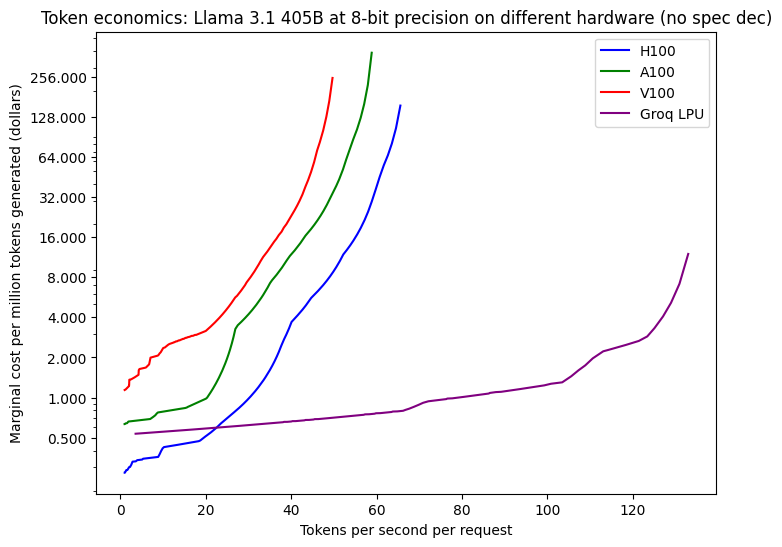

In [248]:
def user_preference_intensity(tokens_per_second_per_request: float, price_per_million_tokens: float):
   return tokens_per_second_per_request**4 / price_per_million_tokens

def preference_maximizing_settings(comparison, token_economics_results):
  results = dict()
  for (comparison_setting, (x_coords, y_coords, gpu_counts, batch_sizes)) in zip(comparison, token_economics_results):
    maximizing_index = np.argmax(user_preference_intensity(x_coords, y_coords))
    results[comparison_setting.name] = {"tokens_per_second_per_request": x_coords[maximizing_index], \
                                        "price_dollars_per_million_tokens": y_coords[maximizing_index], \
                                        "gpus_per_instance": gpu_counts[maximizing_index], \
                                        "batch_size": batch_sizes[maximizing_index]
                                       }
  return results

#token_economics_results = pareto_fronts(llama_comparison, section_2_2_token_latency_seconds)
current_comparison = gpus_comparison
#current_comparison = all_models_comparison
#current_comparison = context_length_comparison
#current_comparison = llama_comparison
#current_comparison = quantization_comparison
#current_comparison = spec_dec_comparison

#current_comparison = tpu_test

token_economics_results = pareto_fronts(current_comparison, token_latency_seconds_default)
#token_economics_results = pareto_fronts(current_comparison, section_2_2_token_latency_seconds)

min_y = min([min(y_coords) for (x_coords, y_coords, gpu_counts, batch_sizes) in token_economics_results])
max_y = max([max(y_coords) for (x_coords, y_coords, gpu_counts, batch_sizes) in token_economics_results])

fig = plt.figure(figsize=(8, 6))

for (comparison_setting, (x_coords, y_coords, gpu_counts, batch_sizes)) in zip(current_comparison, token_economics_results):
  plt.plot(x_coords, y_coords, label=comparison_setting.name, color=comparison_setting.color)
  if comparison_setting.observed_perf != None:
    x_l = []
    y_l = []
    for (x, y) in comparison_setting.observed_perf:
      x_l.append(x)
      y_l.append(y)

    plt.scatter(x_l, y_l, color=comparison_setting.color)

  opt_index = np.argmax(x_coords)
  print("Maximum throughput for %s: %.2f tokens/second/request (using %.2f GPUs at a batch size of %.2f)" % (comparison_setting.name, x_coords[opt_index], \
                                                                                                             gpu_counts[opt_index], batch_sizes[opt_index]))
print("\n")

preference_max_results = preference_maximizing_settings(current_comparison, token_economics_results)
for setting_name in preference_max_results:
  results_dict = preference_max_results[setting_name]
  print("Preferred throughput for %s: %.2f tokens/second/request at %.2f USD/million output tokens (using %.2f GPUs at a batch size of %.2f)" % (setting_name, results_dict["tokens_per_second_per_request"], \
                                                                                                                                                 results_dict["price_dollars_per_million_tokens"], \
                                                                                                                                                 results_dict["gpus_per_instance"], \
                                                                                                                                                 results_dict["batch_size"]))

plt.xlabel("Tokens per second per request")
plt.ylabel("Marginal cost per million tokens generated (dollars)")

plt.yscale("log")
plt.gca().set_yticks([tick for tick in np.logspace(start=-10, stop=10, num=21, base=2) if tick <= max_y and tick >= min_y])
plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda y, _: '%.3f' % y))

plt.title("Token economics: Llama 3.1 405B at 8-bit precision on different hardware (no spec dec)")
plt.legend()

plt.savefig("token_economics_gpu_comparison.pdf")
plt.savefig("token_economics_gpu_comparison.png")
plt.show()